# Data Engineering of the United States's Immigration Datasets.

### Data Engineering Capstone Project

#### Project Summary
For this Capstone project, I have been tasked to conduct a study on the Immigration Dataset of the united states with regards to World Temperature Data, U.S. City Demographic Data, and Airport Code Data. The objective here is to answer questions such as, what is the percentage of people that immigrate to the U.S from countries with cooler weather?, etc..

The goal is to create ETL pipelines that extract each dataset from the source, apply several levels of transformation, then make it ready to be loaded into an analytics database (data warehouse) with a new consolidated data model that serves the analysis and study needs.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Import Library
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, date_add, desc, asc, col, when, to_date, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType, DateType, StructType, StructField
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

%matplotlib inline

### Step 1: Scope the Project and Gather Data

#### Scope:
The scope of the project is to create a data analytics warehouse(DWH) that is suitable for analysis purposes using Apache Spark. It includes extracting data from several sources, transforming each dataset to a specific form, then loading them into a new data model.

This data warehouse will be used to analyze the U.S. immigration data regarding several perspectives, such as world tempreture, demographic data, and others. In the end, every step needed to create the new data model will be pipelined to make it reusable and consistent.

#### Describe and Gather Data: 
The provided datasets for this project are briefly outlined as follows:

**(a) I94 Immigration Data:** This data comes from the US National Tourism and Trade Office. This is where the data comes from:  https://travel.trade.gov/research/reports/i94/historical/2016.html. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.

**(b) World Temperature Data:** This dataset came from Kaggle. You can read more about it here: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data.

**(c) U.S. City Demographic Data:** This data comes from OpenSoft. You can read more about it here: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/.

**(d) Airport Code Table:** This is a simple table of airport codes and corresponding cities. It comes from here:https://datahub.io/core/airport-codes#data.

#### The Immigration dataset

In [2]:
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [3]:
# total count of the records
df_spark.count()

3096313

In [4]:
#write to parquet
#df_spark.write.parquet("sas_data")
#df_spark=spark.read.parquet("sas_data")

#### Snapshot of the Immigration dataset

In [5]:
# Read in the data here
img_df_sample = pd.read_csv('immigration_data_sample.csv')
img_df_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


The definition of the fields is included in the file **I94_SAS_Labels_Descriptions.SAS** We'll primarily be interested in the following fields:

**(a) i94cit** : country of citizenship

**(b) i94res** : country of residence

**(c) i94port**: arrival airport

**(d) arrdate**: arrival date.

**(e) i94mode**

**(f) i94addr**

**(g) depdate**

**(h) i94bir**

**(i) i94visa**

**(j) occup**

**(k) biryear**

**(l) dtaddto**

**(m) gender**

**(n) insnum**

**(o) airline**

**(p) admnum**

**(q) fltno**

**(r) visatype**

#### Snapshot of the Country Code Data.

In [6]:
country_code = {}

# Opening the SAS Label Descriptions File and processing line by line
with open("data_sources/I94_SAS_Labels_Descriptions.SAS") as sas_file:
    for line in sas_file.readlines()[10:298]:
        # Splitting the contents
        pair = line.split('=')
        # Code, country pair values
        code, country = pair[0].strip(), pair[1].strip().strip("'")
        # storing the final results
        country_code[code] = country

# Saving the output as a .csv file for reuse
with open("country_code.csv", mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Code", "Country"])
    for code, country in country_code.items():
        writer.writerow([code, country])

In [7]:
# read the saved .csv file
df_country = pd.read_csv('country_code.csv')
df_country.head()

,Code,Country
0,236,AFGHANISTAN
1,101,ALBANIA
2,316,ALGERIA
3,102,ANDORRA
4,324,ANGOLA


#### Snapshot of the Airport Data.

In [8]:
# Reading the Airports Code Data in the Dataframe
df_airports_code = pd.read_csv("data_sources/airport-codes_csv.csv")
df_airports_code.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### Snapshot of the Global Land Temparature Data.

In [9]:
# Reading the Global Temparature by City Data in the Dataframe
df_temperature = pd.read_csv("../../data2/GlobalLandTemperaturesByCity.csv")
df_temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Snapshot of the the U.S. City Demographic Data.

In [10]:
# Reading the US City Demographic Data in the Dataframe
df_demographics = pd.read_csv("data_sources/us-cities-demographics.csv",delimiter=';')
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Snapshot of the i94port Codes and City Data.

In [11]:
# Initialize the city_code dictionary
city_code = {}

# Processing line by line
with open("data_sources/I94_SAS_Labels_Descriptions.SAS") as sas_file:
    for line in sas_file.readlines()[303:962]:
        # Splitting the contents
        pair = line.split('=')
        # Code, City pair values
        code = pair[0].strip("\t").strip().strip("'")
        city = pair[1].strip('\t').strip().strip("''")
        # Storing the final results
        city_code[code] = city

# Create a DataFrame from the dictionary
portCodes = pd.DataFrame.from_dict(city_code, orient='index', columns=['city'])
portCodes.reset_index(inplace=True)
portCodes.rename(columns={'index': 'code'}, inplace=True)

# Function to split the city column into location and state
def split_city(column_):
    parts = column_.split(',')
    if len(parts) == 2:
        return parts
    return [column_, None]

# Apply the function to split the city column
portCodes[['location', 'state']] = portCodes['city'].apply(split_city).apply(pd.Series)

# Drop the original city column
portCodes.drop(columns=['city'], inplace=True)

# Save the DataFrame to a CSV file
portCodes.to_csv("city_code.csv", index=False)

# Display the DataFrame
portCodes.head()

,code,location,state
0,ANC,ANCHORAGE,AK
1,BAR,BAKER AAF - BAKER ISLAND,AK
2,DAC,DALTONS CACHE,AK
3,PIZ,DEW STATION PT LAY DEW,AK
4,DTH,DUTCH HARBOR,AK


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

In [12]:
dfs = [img_df_sample, df_demographics, df_temperature,  df_airports_code]
# Loop through the list of DataFrames and print their shapes
for idx, df in enumerate(dfs, 1):
    print(f"Shape of DataFrame {idx}: {df.shape}")

Shape of DataFrame 1: (1000, 29)
Shape of DataFrame 2: (2891, 12)
Shape of DataFrame 3: (8599212, 7)
Shape of DataFrame 4: (55075, 12)


#### immigration data

In [13]:
# show the immigration data schema
df_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [14]:
df_spark.count()

3096313

In [15]:
len(df_spark.columns)

28

In [20]:
from pyspark.sql.functions import col, sum
# Count the number of missing values in each column
missing_values_count = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])

# return outcome in pandas
missing_values_count_ = missing_values_count.toPandas()
missing_values_count_

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,0,0,0,0,0,0,0,239,152592,142457,...,3095921,138429,802,477,414269,2982605,83627,0,19549,0


In [21]:
# Total number of records in the DataFrame
total_count = df_spark.count()

# Count the number of missing values in each column and calculate the percentage
missing_values_count_pd = df_spark.select([
    ((sum(col(c).isNull().cast("int")) / total_count) * 100).alias(c) for c in df_spark.columns
]).toPandas()

# Filter columns with more than 90% missing values
deleted_columns = missing_values_count_pd.loc[:, (missing_values_count_pd > 90).any()]

# Display the filtered result
deleted_columns

,occup,entdepu,insnum
0,99.737559,99.98734,96.327632


#### Immigration Data Findings
**Data Shape:** There are 3,096,313 records and 28 fields

**cicid** This field is unique and can serve as a primary key for the immigration table

**Duplicated Rows:** There are 0 number sof duplicated row

**Columns to be Dropped:** The following columns will be dropped - 'entdepu', 'insnum' and 'occup'

**Unnamed Column:** This will be dropped as well

#### Temperature data

In [22]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [23]:
df_temperature['Country'].nunique()

159

In [24]:
# min and max date
df_temperature['dt'].min(), df_temperature['dt'].max()

('1743-11-01', '2013-09-01')

In [25]:
# Calculate the number of missing values in each column
missing_values_count = df_temperature.isnull().sum()
missing_values_count

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [26]:
# Calculate the total number of rows in the DataFrame
total_rows = len(df_temperature)

# Calculate the percentage of missing values in each column
missing_values_percentage = round((missing_values_count / total_rows) * 100, 2)
missing_values_percentage

dt                               0.00
AverageTemperature               4.23
AverageTemperatureUncertainty    4.23
City                             0.00
Country                          0.00
Latitude                         0.00
Longitude                        0.00
dtype: float64

#### Temperature Data Findings
**Other Countries** This dataset holds temperature of other countries and so we need to limit to only US.

**Missing Records** There are 364130 missing records for both AverageTemperature and AverageTemperatureUncertainty which 4.23% of the total records available.

**Shape** This datatset has 8,599,212 records and 7 fields.

**Duplicated Rows** there are no duplicated rows.

### Airport data

In [27]:
df_airports_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [28]:
df_airports_code['iso_country'].nunique()

243

In [29]:
df_airports_code.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [30]:
df_airports_code['continent'].value_counts()

EU    7840
SA    7709
AS    5350
AF    3362
OC    3067
AN      28
Name: continent, dtype: int64

In [31]:
# Let's quickly check the missing country values to see if the continent data is filled out
df_airports_code[df_airports_code['iso_country'].isna()].groupby('continent')['continent'].count()

continent
AF    247
Name: continent, dtype: int64

In [32]:
# Group the DataFrame by 'continent'
grouped = df_airports_code.groupby('continent')
# Calculate the percentage of missing data for each group
df_airports_missing_data_prct = grouped.apply(lambda x: x.isnull().sum() / len(x) * 100)
df_airports_missing_data_prct

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
continent,,,,,,,,,,,,
AF,0.0,0.0,0.0,15.020821,0.0,7.346817,0.0,14.455681,36.823319,68.143962,98.185604,0.0
AN,0.0,0.0,0.0,7.142857,0.0,0.000000,0.0,42.857143,14.285714,96.428571,64.285714,0.0
AS,0.0,0.0,0.0,36.411215,0.0,0.000000,0.0,15.383178,51.084112,67.738318,88.411215,0.0
EU,0.0,0.0,0.0,28.201531,0.0,0.000000,0.0,17.410714,50.612245,85.714286,89.400510,0.0
OC,0.0,0.0,0.0,35.409195,0.0,0.000000,0.0,50.701011,12.520378,57.091620,76.882948,0.0
SA,0.0,0.0,0.0,5.123881,0.0,0.000000,0.0,6.109742,25.269166,87.183811,71.020885,0.0


In [33]:
# Calculate the number of missing values in each column
missing_values_count = df_airports_code.isnull().sum()
missing_values_count

ident               0
type                0
name                0
elevation_ft     7006
continent       27719
iso_country       247
iso_region          0
municipality     5676
gps_code        14045
iata_code       45886
local_code      26389
coordinates         0
dtype: int64

In [34]:
# Calculate the total number of rows in the DataFrame
total_rows = len(df_airports_code)

# Calculate the percentage of missing values in each column
missing_values_percentage = round((missing_values_count / total_rows) * 100, 2)
missing_values_percentage

ident            0.00
type             0.00
name             0.00
elevation_ft    12.72
continent       50.33
iso_country      0.45
iso_region       0.00
municipality    10.31
gps_code        25.50
iata_code       83.32
local_code      47.91
coordinates      0.00
dtype: float64

#### Airport Data Findings
**ISO_COUNTRY** This 243 countries re present in the dataset.

**ISO_COUNTRY FROM AF** There are 3362 records from the continent of AF, out which 247 are missing. 

#### Demographic data

In [35]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


In [36]:
df_demographics.isnull().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

In [37]:
# Testing the useful Primary Key Combination
df_demographics[df_demographics[['City', 'State','Race']].duplicated()]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count


#### Demographics Data Findings
**Primary Key** The combination of 'City', 'State','Race' can be used a sa joining Key. 

**Missing Records** There are no obvious missing records.

#### Cleaning Steps
Document steps necessary to clean the data

##### Immgration Data

In [38]:
# We create a view of the immigration dataset
df_spark_ = df_spark.createOrReplaceTempView("us_im_table")

## SAS correspond to the number of days since 1960-01-01. Therfore, we compute the arrival dates by adding arrdate to 1960-01-01
df_spark_ = spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM us_im_table")
df_spark_.createOrReplaceTempView("us_im_table")

# Replace the data in the I94VISA columns
spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM us_im_table""").createOrReplaceTempView("us_im_table")

spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM us_im_table""").createOrReplaceTempView("us_im_table")

In [39]:
#.createOrReplaceTempView("us_im_table")
spark.sql("""
SELECT COUNT(*)
FROM us_im_table
WHERE departure_date <= arrival_date
""").show()

+--------+
|count(1)|
+--------+
|     375|
+--------+



In [40]:
#Validating the missing numbers
spark.sql("SELECT count(*) FROM us_im_table WHERE departure_date = 'N/A'").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [41]:
spark.sql("""
SELECT arrival_date, departure_date
FROM us_im_table
WHERE departure_date <= arrival_date
""").show(5)

+------------+--------------+
|arrival_date|departure_date|
+------------+--------------+
|  2016-04-01|    2016-03-31|
|  2016-04-02|    2016-03-19|
|  2016-04-02|    2016-01-26|
|  2016-04-02|    2016-04-01|
|  2016-04-02|    2016-01-31|
+------------+--------------+
only showing top 5 rows



In [42]:
#check distinct departure dates
spark.sql("SELECT COUNT (DISTINCT departure_date) FROM us_im_table ").show()

#check distinct arrival dates
spark.sql("SELECT COUNT (DISTINCT arrival_date) FROM us_im_table ").show()

#check the common values between the two sets
spark.sql("""   SELECT COUNT(DISTINCT departure_date) 
                FROM us_im_table 
                WHERE departure_date IN (
                    SELECT DISTINCT arrival_date FROM us_im_table
                ) 
                """).show()

+------------------------------+
|count(DISTINCT departure_date)|
+------------------------------+
|                           235|
+------------------------------+

+----------------------------+
|count(DISTINCT arrival_date)|
+----------------------------+
|                          30|
+----------------------------+

+------------------------------+
|count(DISTINCT departure_date)|
+------------------------------+
|                            30|
+------------------------------+



In [43]:
spark.sql("""
SELECT *
FROM us_im_table
WHERE departure_date >= arrival_date
""").createOrReplaceTempView("us_im_table")

In [44]:
spark.sql("SELECT (2016-biryear)-i94bir AS difference, count(*) FROM us_im_table WHERE i94bir IS NOT NULL GROUP BY difference").show()

+----------+--------+
|difference|count(1)|
+----------+--------+
|       0.0| 2953435|
+----------+--------+



In [45]:
# exclude where Gender is Missing
spark.sql("""SELECT * FROM us_im_table WHERE gender IN ('F', 'M')""").createOrReplaceTempView("us_im_table")

In [46]:
# To check the citizenship and residence data to see if any values are missing
#citizenship countries
spark.sql("""
SELECT count(*) 
FROM us_im_table
WHERE i94cit IS NULL
""").show()

#residence countries
spark.sql("""
SELECT count(*) 
FROM us_im_table
WHERE i94res IS NULL
""").show()

#reported address
spark.sql("""
SELECT count(*) 
FROM us_im_table
WHERE i94addr IS NULL
""").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|  114019|
+--------+



In [47]:
df_spark_ = spark.sql("""SELECT * FROM us_im_table""") 

In [48]:
df_spark_.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'occup',
 'entdepa',
 'entdepd',
 'entdepu',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'insnum',
 'airline',
 'admnum',
 'fltno',
 'visatype',
 'arrival_date',
 'visa_type',
 'departure_date']

##### Cleaning Temperature

In [49]:
# Our temprature datatset has got other countries, it will make sense to keep only to the United States
df_temperature_ = df_temperature[df_temperature['Country']=='United States']

# Convert the date to datetime objects
df_temperature_['Datetime_'] = pd.to_datetime(df_temperature.dt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [50]:
# Remove all dates prior to 1950. The logic here is base don the fact there are no commercial air travel  prior this date.
df_temperature_=df_temperature_[df_temperature_['Datetime_']>"1950-01-01"].copy()

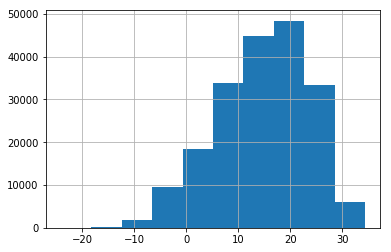

In [51]:
# Histogram of Average Temperature values
df_temperature_['AverageTemperature'].hist();

In [52]:
df_temperature_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196348 entries, 49116 to 8439246
Data columns (total 8 columns):
dt                               196348 non-null object
AverageTemperature               196347 non-null float64
AverageTemperatureUncertainty    196347 non-null float64
City                             196348 non-null object
Country                          196348 non-null object
Latitude                         196348 non-null object
Longitude                        196348 non-null object
Datetime_                        196348 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 13.5+ MB


##### Cleaning AIRPORT Data

In [53]:
# Since all missing values are in africa, we simly remove them from the dataset
df_airports_code_ = df_airports_code[df_airports_code['iso_country'].fillna('').str.upper().str.contains('US')].copy()

In [54]:
excludedValues = ['closed', 'heliport', 'seaplane_base', 'balloonport']
df_airports_code_ = df_airports_code_[~df_airports_code_['type'].str.strip().isin(excludedValues)].copy()

In [55]:
df_airports_code_ = df_airports_code_[~df_airports_code_['municipality'].isna()].copy()

In [56]:
df_airports_code_.municipality = df_airports_code_.municipality.str.upper()

In [57]:
# apply len to the iso_region field to see which ones are longer than 5 characters since the field is a combination of US and state code
df_airports_code_['len'] = df_airports_code_["iso_region"].apply(len)
# let's remove the codes that are incorrect.
df_airports_code_ = df_airports_code_[df_airports_code_['len']==5].copy()
# finally, let's extract the state code
df_airports_code_['state'] = df_airports_code_['iso_region'].str.strip().str.split("-", n = 1, expand = True)[1]

In [58]:
df_airports_code_.isnull().sum()

ident               0
type                0
name                0
elevation_ft       36
continent       14529
iso_country         0
iso_region          0
municipality        0
gps_code          366
iata_code       12664
local_code        158
coordinates         0
len                 0
state               0
dtype: int64

#### Demographic data

In [59]:
df_demographics['City'] = df_demographics.City.str.upper().str.strip()
# remove any leading or trailing spaces and convert to upper case
df_demographics.City = df_demographics.City.str.strip().str.upper()

In [60]:
df_demographics['city_state_race'] = df_demographics['City'] + df_demographics['State'] + df_demographics['Race']

In [61]:
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count,city_state_race
0,SILVER SPRING,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924,SILVER SPRINGMarylandHispanic or Latino
1,QUINCY,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723,QUINCYMassachusettsWhite
2,HOOVER,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759,HOOVERAlabamaAsian
3,RANCHO CUCAMONGA,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437,RANCHO CUCAMONGACaliforniaBlack or African-Ame...
4,NEWARK,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402,NEWARKNew JerseyWhite


In [62]:
df_demographics.isnull().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
city_state_race            0
dtype: int64

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model


The idea here is to track the inflow of travellers into the US and as such the model is designed as a **Star schema**. In this case, the immigration data will serve as our **Fact Table**. Our **fact_immigration** table while other perspective information and features that include an object in the fact table are dimension tables. 

The idea of using a star schema for this task feel the most suitable for the analytics purposes of the immigration data, since it connects relevant information within a proper number of aggregations and links requiring fewer joins, and decreases the records duplication at an adequate level with respect to schema complexity.

**fact_immigration** table includes the following fields :

* cicid
* citizenship_country
* residence_country,
* city
* state
* arrival_date
* departure_date
* age
* visa_type
* detailed_visa_type

The dimension tables uses with four dimensions to aggregate our data:\

**dim_time :** to aggregate the data using various time units some of which are:

* date
* year
* month
* day
* week
* weekday
* dayofyear

**dim_airports :** Used to determine the areas with the largest flow of travelers. Fileds are:

* ident
* type
* name
* elevation_ft
* state
* municipality
* iata_code

**dim_city_demographics :** To look at the demographic data of the areas with the most travelers and potentially look at the impact of the flow of travellers on the demographic data (if it were updated on a regular basis). The fiels available will be:

* City
* state
* median_age
* male_population
* female_population
* total population
* Foreign_born
* Average_Household_Size
* Race
* Count

**dim_temperatures :** to look at the temperature data of the cities where traveller entry and departure is being reported. The fields included will be:

* date
* City
* average temperature
* average temperature uncertainty

#### 3.2 Mapping Out Data Pipelines
**List the steps necessary to pipeline the data into the chosen data model**

1. Clean the data (Applied in Step 2).
1. Create Dimension tables.
1. Create Fact table.
1. Write data into parquet files.
1. Perform data quality checks.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [63]:
df_demographics_spark = spark.read.format("csv").option("header", "true").option("delimiter", ";").load('us-cities-demographics.csv')

In [64]:
df_demographics_spark.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [65]:
df_demographics.dtypes

City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
city_state_race            object
dtype: object

In [66]:
spark.createDataFrame(df_demographics).printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: double (nullable = true)
 |-- Female Population: double (nullable = true)
 |-- Total Population: long (nullable = true)
 |-- Number of Veterans: double (nullable = true)
 |-- Foreign-born: double (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: long (nullable = true)
 |-- city_state_race: string (nullable = true)



#### Staging of the data

In [67]:
# load dictionary data
df_countryCodes = pd.read_csv('country_code.csv')
df_i94portCodes = pd.read_csv('city_code.csv')

# load the various csv files into pandas dataframes
df_demographics = pd.read_csv('us-cities-demographics.csv', sep=';')
df_temperature = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')

# load the SAS data
df_immigration=spark.read.parquet("sas_data")

In [68]:
#df_i94portCodes = pd.read_csv('city_code.csv')

#### Data Transformation

In [69]:
# let's convert the data dictionaries to views in our spark context to perform SQL operations with them
spark_df_countryCodes = spark.createDataFrame(df_countryCodes)
spark_df_countryCodes .createOrReplaceTempView("countryCodes")

# remove all entries with null values as they are either un reported or outside the US
df_i94portCodes = df_i94portCodes[~df_i94portCodes.state.isna()].copy()

# We need to exclude values for airports outside of the US. 
nonUSstates = ['CANADA', 'Canada', 'NETHERLANDS', 'NETH ANTILLES', 'THAILAND', 'ETHIOPIA', 'PRC', 'BERMUDA', 'COLOMBIA', 'ARGENTINA', 'MEXICO', 
               'BRAZIL', 'URUGUAY', 'IRELAND', 'GABON', 'BAHAMAS', 'MX', 'CAYMAN ISLAND', 'SEOUL KOREA', 'JAPAN', 'ROMANIA', 'INDONESIA',
               'SOUTH AFRICA', 'ENGLAND', 'KENYA', 'TURK & CAIMAN', 'PANAMA', 'NEW GUINEA', 'ECUADOR', 'ITALY', 'EL SALVADOR']

In [70]:
df_i94portCodes = df_i94portCodes[~df_i94portCodes.state.isin(nonUSstates)].copy()

In [71]:
spark_df_i94portCodes = spark.createDataFrame(df_i94portCodes)
spark_df_i94portCodes .createOrReplaceTempView("i94portCodes")

In [72]:
df_immigration.createOrReplaceTempView("immig_table")
# Remove all entries into the united states that weren't via air travel
spark.sql("""
SELECT *
FROM immig_table
WHERE i94mode = 1
""").createOrReplaceTempView("immig_table")

In [73]:
# drop rows where the gender values entered is undefined
spark.sql("""SELECT * FROM immig_table WHERE gender IN ('F', 'M')""").createOrReplaceTempView("immig_table")

In [74]:
# convert the arrival dates into a useable value
spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM immig_table").createOrReplaceTempView("immig_table")

In [75]:
# convert the departure dates into a useable value
spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

In [76]:
#country of citizenship
spark.sql("""
SELECT im.*, cc.country AS citizenship_country
FROM immig_table im
INNER JOIN countryCodes cc
ON im.i94cit = cc.code
""").createOrReplaceTempView("immig_table")

In [77]:
#country of residence
spark.sql("""
SELECT im.*, cc.country AS residence_country
FROM immig_table im
INNER JOIN countryCodes cc
ON im.i94res = cc.code
""").createOrReplaceTempView("immig_table")

In [78]:
# Add visa character string aggregation
spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

In [79]:
# Add entry_port names and entry port states to the view
spark.sql("""
SELECT im.*, pc.location AS entry_port, pc.state AS entry_port_state
FROM immig_table im 
INNER JOIN i94portCodes pc
ON im.i94port = pc.code
""").createOrReplaceTempView("immig_table")

In [80]:
# Compute the age of each individual and add it to the view
spark.sql("""
SELECT *, (2016-biryear) AS age 
FROM immig_table
""").createOrReplaceTempView("immig_table")

In [81]:
# Insert the immigration fact data into a spark dataframe
fact_immigration = spark.sql("""
                        SELECT 
                            cicid, 
                            citizenship_country,
                            residence_country,
                            TRIM(UPPER (entry_port)) AS city,
                            TRIM(UPPER (entry_port_state)) AS state,
                            arrival_date,
                            departure_date,
                            age,
                            visa_type,
                            visatype AS detailed_visa_type

                        FROM immig_table
""")

In [82]:
# extract all distinct dates from arrival and departure dates to create dimension table
dim_time = spark.sql("""
SELECT DISTINCT arrival_date AS date
FROM immig_table
UNION
SELECT DISTINCT departure_date AS date
FROM immig_table
WHERE departure_date IS NOT NULL
""")
dim_time.createOrReplaceTempView("dim_time_table")

In [83]:
dim_time = spark.sql("""
SELECT date, YEAR(date) AS year, MONTH(date) AS month, DAY(date) AS day, WEEKOFYEAR(date) AS week, DAYOFWEEK(date) as weekday, DAYOFYEAR(date) year_day
FROM dim_time_table
ORDER BY date ASC
""")

In [84]:
# Keep only data for the United States
df_temperature = df_temperature[df_temperature['Country']=='United States'].copy()

# Convert the date to datetime objects
df_temperature['date'] = pd.to_datetime(df_temperature.dt)

# Remove all dates prior to 1950
df_temperature=df_temperature[df_temperature['date']>"1950-01-01"].copy()

In [85]:
# convert the city names to upper case
df_temperature.City = df_temperature.City.str.strip().str.upper() 

In [86]:
# convert the dataframes from pandas to spark
spark_df_temperature = spark.createDataFrame(df_temperature)
spark_df_temperature .createOrReplaceTempView("temperature")

In [87]:
dim_temperature = spark.sql("""
SELECT
    DISTINCT date, city,
    AVG(AverageTemperature) OVER (PARTITION BY date, City) AS average_temperature, 
    AVG(AverageTemperatureUncertainty)  OVER (PARTITION BY date, City) AS average_termperature_uncertainty
    
FROM temperature
""")

In [88]:
df_demographics.City = df_demographics.City.str.strip().str.upper()
df_demographics['State Code'] = df_demographics['State Code'].str.strip().str.upper()
df_demographics.Race = df_demographics.Race.str.strip().str.upper()

In [89]:
# convert the dataframes from pandas to spark
spark_df_demographics = spark.createDataFrame(df_demographics)
spark_df_demographics.createOrReplaceTempView("demographics")

In [90]:
# insert data into the demographics dim table
dim_demographics = spark.sql("""
                                SELECT  City, 
                                        State, 
                                        `Median Age` AS median_age, 
                                        `Male Population` AS male_population, 
                                        `Female Population` AS female_population, 
                                        `Total Population` AS total_population, 
                                        `Foreign-born` AS foreign_born, 
                                        `Average Household Size` AS average_household_size, 
                                        `State Code` AS state_code, 
                                        Race, 
                                        Count
                                FROM demographics
""")

In [91]:
#The airport dataset contains a lot of nulls. We'll load the csv directly into a spark dataframe to avoid having to deal with converting pandas NaN into nulls
spark_df_airports = spark.read.format("csv").option("header", "true").load('airport-codes_csv.csv')
spark_df_airports.createOrReplaceTempView("airports")

In [92]:
#equivalent to the following pandas code:
spark.sql("""
SELECT *
FROM airports
WHERE iso_country IS NOT NULL
AND UPPER(TRIM(iso_country)) LIKE 'US'
""").createOrReplaceTempView("airports")

In [93]:
spark.sql("""
SELECT *
FROM airports
WHERE LOWER(TRIM(type)) NOT IN ('closed', 'heliport', 'seaplane_base', 'balloonport')
AND municipality IS NOT NULL
AND LENGTH(iso_region) = 5
""").createOrReplaceTempView("airports")

In [94]:
dim_airports = spark.sql("""
SELECT TRIM(ident) AS ident, type, name, elevation_ft, SUBSTR(iso_region, 4) AS state, TRIM(UPPER(municipality)) AS municipality, iata_code
FROM airports
""")

#### Saving the data in parquet format

In [96]:
dim_demographics.write.parquet("dim_demographics")
dim_time.write.parquet("dim_time")
dim_airports.write.parquet("dim_airports")
dim_temperature.write.parquet("dim_temperature")
fact_immigration.write.parquet("fact_immigration")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
#### Running Quality Checks

In [97]:
#Let's check some things in our data
dim_demographics.createOrReplaceTempView("dim_demographics")
dim_time.createOrReplaceTempView("dim_time")
dim_airports.createOrReplaceTempView("dim_airports")
dim_temperature.createOrReplaceTempView("dim_temperature")
fact_immigration.createOrReplaceTempView("fact_immigration")

In [98]:
# we define the following function to check for null values
def nullValueCheck(spark_ctxt, tables_to_check):
    """
    This function performs null value checks on specific columns of given tables received as parameters and raises a ValueError exception when null values are encountered.
    It receives the following parameters:
    spark_ctxt: spark context where the data quality check is to be performed
    tables_to_check: A dictionary containing (table, columns) pairs specifying for each table, which column is to be checked for null values.   
    """  
    for table in tables_to_check:
        print(f"Performing data quality check on table {table}...")
        for column in tables_to_check[table]:
            returnedVal = spark_ctxt.sql(f"""SELECT COUNT(*) as nbr FROM {table} WHERE {column} IS NULL""")
            if returnedVal.head()[0] > 0:
                raise ValueError(f"Data quality check failed! Found NULL values in {column} column!")
        print(f"Table {table} passed.")

In [99]:
#dictionary of tables and columns to be checked
tables_to_check = { 'fact_immigration' : ['cicid'], 'dim_time':['date'], 'dim_demographics': ['City','state_code'], 'dim_airports':['ident'], 'dim_temperature':['date','City']}

#We call our function on the spark context
nullValueCheck(spark, tables_to_check)

Performing data quality check on table fact_immigration...
Table fact_immigration passed.
Performing data quality check on table dim_time...
Table dim_time passed.
Performing data quality check on table dim_demographics...
Table dim_demographics passed.
Performing data quality check on table dim_airports...
Table dim_airports passed.
Performing data quality check on table dim_temperature...
Table dim_temperature passed.


In [100]:
#time dimension verification

#check the number of rows in our time table : 192 expected
spark.sql("""
SELECT COUNT(*) - 192
FROM dim_time
""").show()

# make sure each row has a distinct date key : 192 expected
spark.sql("""
SELECT COUNT(DISTINCT date) - 192
FROM dim_time
""").show()

# we could also subtract the result of one query from the other


# and make sure all dates from the fact table are included in the time dimension (NULL is the expected result)
spark.sql("""
SELECT DISTINCT date
FROM dim_time

MINUS

(SELECT DISTINCT arrival_date AS date
FROM immig_table
UNION
SELECT DISTINCT departure_date AS date
FROM immig_table
WHERE departure_date IS NOT NULL)

""").show()

+--------------------------------+
|(count(1) - CAST(192 AS BIGINT))|
+--------------------------------+
|                              -7|
+--------------------------------+

+--------------------------------------------+
|(count(DISTINCT date) - CAST(192 AS BIGINT))|
+--------------------------------------------+
|                                          -7|
+--------------------------------------------+

+----+
|date|
+----+
+----+



In [101]:
#immigration verification

# The number of primary key from the staging table (2165257 expected)
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM immig_table
""").show()

#should match the primary key count from the fact table (2165257 expected)
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM fact_immigration
""").show()

#and should match the row count from the fact table since it is also the primary key (2165257 expected)
spark.sql("""
SELECT count(*) - 2165257
FROM fact_immigration
""").show()

+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                          -151553|
+-------------------------------------------------+

+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                          -151553|
+-------------------------------------------------+

+------------------------------------+
|(count(1) - CAST(2165257 AS BIGINT))|
+------------------------------------+
|                             -151553|
+------------------------------------+



In [102]:
# Let's check the demographics dimension table (2891 expected) 
spark.sql("""
SELECT count(*) - 2891
FROM dim_demographics
""").show()

spark.sql("""
SELECT COUNT(DISTINCT city, state, race) - 2891
FROM dim_demographics
""").show()

+---------------------------------+
|(count(1) - CAST(2891 AS BIGINT))|
+---------------------------------+
|                                0|
+---------------------------------+

+----------------------------------------------------------+
|(count(DISTINCT city, state, race) - CAST(2891 AS BIGINT))|
+----------------------------------------------------------+
|                                                         0|
+----------------------------------------------------------+



In [103]:
# Let's check the primary key for airports (expected 14529)
spark.sql("""
SELECT count(*) - 14529
FROM dim_airports
""").show()

spark.sql("""
SELECT COUNT(DISTINCT ident) - 14529
FROM dim_airports
""").show()

+----------------------------------+
|(count(1) - CAST(14529 AS BIGINT))|
+----------------------------------+
|                                 0|
+----------------------------------+

+-----------------------------------------------+
|(count(DISTINCT ident) - CAST(14529 AS BIGINT))|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [104]:
#finally, city + date is our primary key for the temperature (expected 189472)

spark.sql("""
SELECT count(*) - 189472
FROM dim_temperature
""").show()

spark.sql("""
SELECT COUNT(DISTINCT date, city) - 189472
FROM dim_temperature
""").show()

+-----------------------------------+
|(count(1) - CAST(189472 AS BIGINT))|
+-----------------------------------+
|                                  0|
+-----------------------------------+

+-----------------------------------------------------+
|(count(DISTINCT date, city) - CAST(189472 AS BIGINT))|
+-----------------------------------------------------+
|                                                    0|
+-----------------------------------------------------+



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

**1. fact_immigration**

**Primary key:** cicid

* cicid (double): Unique identifier for each traveller
* citizenship_country (string): Traveller's country of citizenship
* residence_country (string): Traveller's country of residence
* city (string): City where the entry port of the traveller is located
* state (string): State where the entry port of the traveller is located
* arrival_date (date): Traveller's arrival date
* departure_date (string): Traveller's departure date, if known
* age (double):  Traveller's age
* visa_type (string): aggregate visa type. Possible values are:
		Business,
		Pleasure,
		Student,
* detailed_visa_type (string): Detailed visa types. Numerous values are available. Not all could be identified:
		B1: B1 visa is for business visits valid for up to a year
		B2: B2 visa is for pleasure visits valid for up to a year
		CP: could not find a definition
		E2: E2 investor visas allows foreign investors to enter and work inside of the United States based on a substantial investment
		F1: F1 visas are used by non-immigrant students for Academic and Language training Courses. 
		F2: F2 visas are used by the dependents of F1 visa holders
		GMT: could not find a definition
		M1: for students enrolled in non-academic or “vocational study”. Mechanical, language, cooking classes, etc...
		WB: Waiver Program (WT/WB Status) travel to the United States for tourism or business for stays of 90 days or less without obtaining a visa.
		WT: Waiver Program (WT/WB Status) travel to the United States for tourism or business for stays of 90 days or less without obtaining a visa.
 


**2. dim_demographics**

**Primary key:** City, state_code, Race

* City (String): Name of the city
* State (String): Name of the state
* median_age (double): Median age for the city
* male_population (double): Size of the male population
* female_population (double): Size of the female population
* total_population (long) : Total population
* foreign_born (double): Number of foreign born residents
* average_household_size (double): Average size of a household
* state_code (String): Two letter state code
* Race (String): Racial category selected by respondants. Possible values are:
			Hispanic or Latino
			White
			Asian
			Black or African-American
			American Indian and Alaska Native
* Count (long): Number of respondants (ie Size) for the combination City, State, Race

**3. dim_time**

**Primary key:** date

* date (string): date in the format yyyy-mm-dd
* year (integer): year for the given date, available for aggregation
* month (integer): month for the given date, available for aggregation
* day (integer): day for the given date, available for aggregation
* week (integer): week for the given date, available for aggregation (values between 0 and 52)
* weekday (integer): weekday for the given date, available for aggregation (values between 0 and 6)
* year_day (integer): year for the given date, available for aggregation

**4. dim_airports**

**Primary key:** ident

* ident (string): Airport identified
* type (string): Type of airport. Possible values are:
		large_airport
		medium_airport
		small_airport
* name (string): Name of the airport 
* elevation_ft (string):  Elevation of the airport
* state (string): State where the airport is located
* municipality (string): Name of the city closest to the airport
* iata_code (string): iata_code that appears to airplane tickets and baggages

**5. dim_temperature**

**Primary key:** date, city

* date (timestamp): date when the temperature was registered
* city (string): city where the termperature was registered
* average_temperature (double): average temperature recorded for the day in the specified city
* average_termperature_uncertainty (double): average uncertainty recored 

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

- Taking the volume of data into perspective the choice of is a no brainer since it over distributed processing capability for processing alrge amount of data.

* Propose how often the data should be updated and why.

- it would be of immense benefits if these data is refreshed on a monthly basis as this woud help the analytic steam to be able to understand seasonaity, volume of travellers on a month by month basis among other things.


* Write a description of how you would approach the problem differently under the following scenarios:
    - The data was increased by 100x.
        - Even though Spark can handle the job but we would use more processing power and increase the number of nodes in the cluster. Also, we would implement the pipeline and engineering work with more sophisticated processing and storage functions such as Amazon Redshift and Amazon EMR.
     
    - The data populates a dashboard that must be updated on a daily basis by 7am every day.
        - In this case, Apache Airflow will be used to schedule and run data pipelines, that is to ensure timeliness, consistency, and stability.
    - The database needed to be accessed by 100+ people.
        - In this scenario, we would move our analytics database into Amazon Redshift which can handle massive request volumes and is easily scalable.